In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
import shapely
import tabs

/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

In [4]:
df = pd.read_csv('../../../data/HRRO3 March 25-27 2018/SCS_ Pelican/MIDAS/MIDAS_001.elg', parse_dates=[[0,1]], index_col=0, na_values='na', nrows=95000)

In [5]:
#convert from shoved together numbers to decimal degrees by pulling apart number as a string
df.loc[:,'ADU800-GGA-Lat'] = [float(str(la)[:2]) + float(str(la)[2:-1])/60 for la in df['ADU800-GGA-Lat']]
#and again for longitude
df.loc[:,'ADU800-GGA-Lon'] = [-(float(str(lo)[1:3]) + float(str(lo)[3:-1])/60) for lo in df['ADU800-GGA-Lon']]

In [6]:
tdf = tabs.read('g06010', '2018-3-25', '2018-3-27') #g06010 bouy

# Figure without Galveston Bay

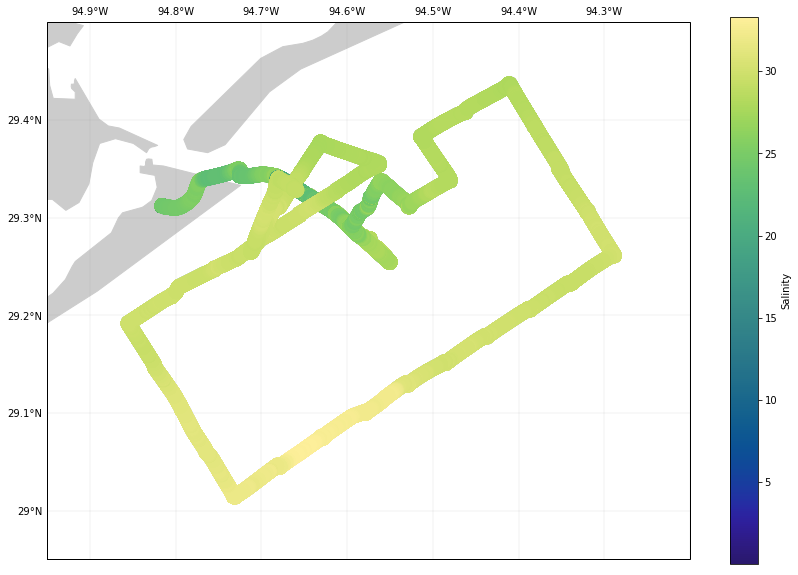

In [7]:
# Figure without Galveston Bay
fig = plt.figure(figsize=(12, 8)) # (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
#extent controls bounds of cruise
ax.set_extent([-94.95, -94.2, 28.95, 29.5], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

mappable = ax.scatter(df['ADU800-GGA-Lon'], df['ADU800-GGA-Lat'], c=df['Thermosalinograph-Data-Salinity'], s=200, cmap=cmo.haline, transform=pc, zorder=10)
cb = fig.colorbar(mappable)
cb.set_label('Salinity')

# Ebb Tide Subplots

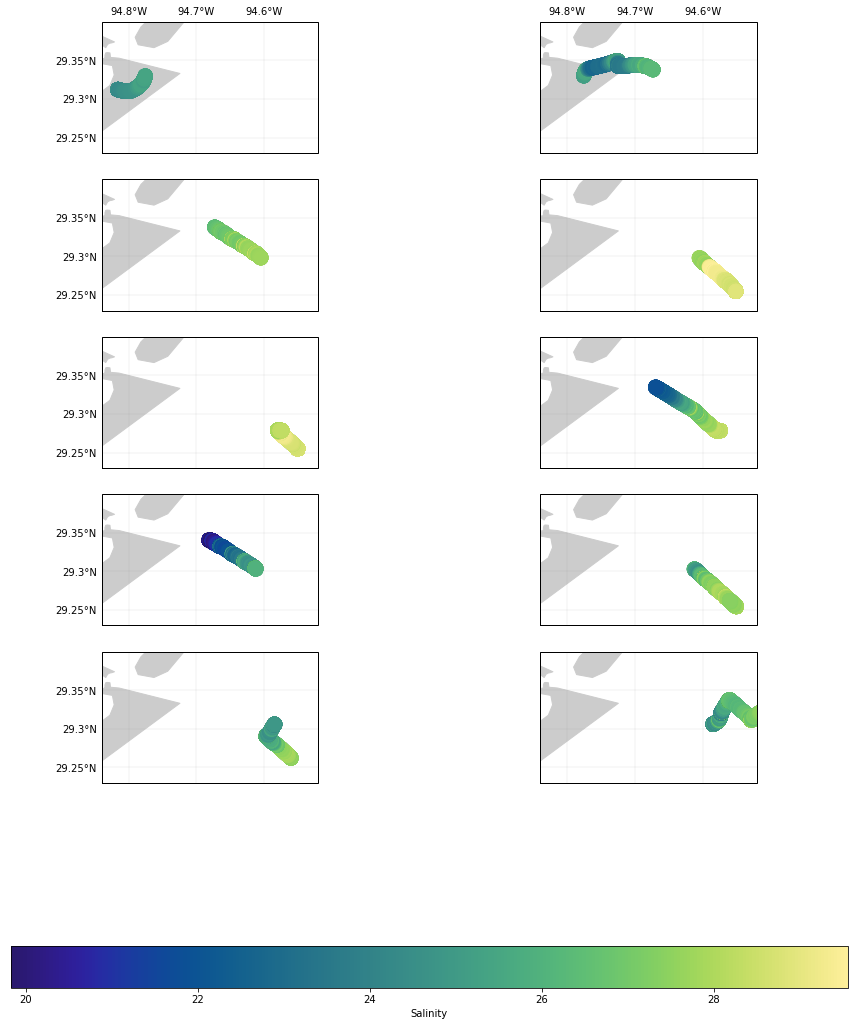

In [13]:
fig, axes = plt.subplots(nrows = 5, ncols = 2,subplot_kw = dict(projection = merc), figsize = (15,20))
dstartoverall = pd.Timestamp('2018-3-25 05:30')
plt.subplots_adjust(wspace = .1) #adjust this for maximum plot space
vmin = df['Thermosalinograph-Data-Salinity'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].min()
vmax = df['Thermosalinograph-Data-Salinity'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].max()

for i,ax in enumerate(axes.flatten()):
    ax.set_extent([-94.84, -94.52, 29.23, 29.4], pc)
    gl = ax.gridlines(linewidth = 0.2, color = 'gray', alpha = 0.5, linestyle = '-', draw_labels = True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-100, -70, .1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 40, .05))
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    ax.add_feature(land_10m, facecolor = '0.8')
    ax.set_facecolor('0.8')
    
    dstart = dstartoverall + i*pd.Timedelta('1 hour')
    dend = dstart + pd.Timedelta('1 hour') 
    
    if i >= 2:
        gl.xlabels_top = False
        
    if i in [1, 3, 5, 7, 9] : 
        gl.ylabels_left = False
    
    mappable = ax.scatter(df['ADU800-GGA-Lon'][dstart:dend], df['ADU800-GGA-Lat'][dstart:dend], c=df['Thermosalinograph-Data-Salinity'][dstart:dend], s=200, cmap=cmo.haline, transform=pc, zorder=10, vmin = vmin, vmax = vmax)
cb = fig.colorbar(mappable, orientation = 'horizontal', ax=axes.ravel().tolist())
cb.set_label('Salinity')
    

fig.savefig('test.png')



# Flood Tide

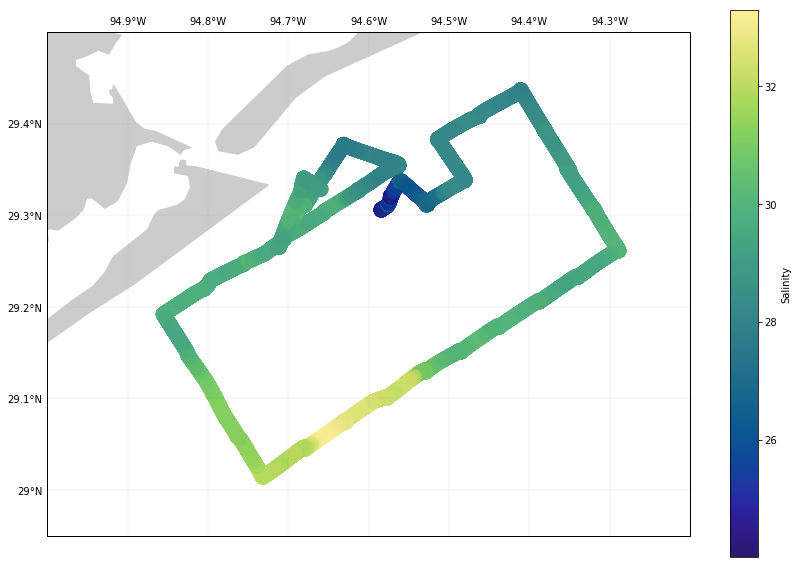

In [10]:
fig = plt.figure(figsize=(12, 8)) # (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
#extent controls bounds of cruise
ax.set_extent([-95.0, -94.2, 28.95, 29.5], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

mappable = ax.scatter(df['ADU800-GGA-Lon']['2018-3-25 14:30':'2018-3-26 07:30'], df['ADU800-GGA-Lat']['2018-3-25 14:30':'2018-3-26 07:30'], c=df['Thermosalinograph-Data-Salinity']['2018-3-25 14:30':'2018-3-26 07:30'], s=200, cmap=cmo.haline, transform=pc, alpha=0.1)
cb = fig.colorbar(mappable)
cb.set_alpha(1)
cb.draw_all()
cb.set_label('Salinity')

In [17]:
fig, axes = plt.subplots(nrows = 5, ncols = 2,subplot_kw = dict(projection = merc), figsize = (15,20))
dstartoverall = pd.Timestamp('2018-3-26 07:30')
plt.subplots_adjust(wspace = .1) #adjust this for maximum plot space
vmin = df['Thermosalinograph-Data-Salinity'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].min()
vmax = df['Thermosalinograph-Data-Salinity'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].max()

for i,ax in enumerate(axes.flatten()):
    ax.set_extent([-94.84, -94.52, 29.23, 29.4], pc)
    gl = ax.gridlines(linewidth = 0.2, color = 'gray', alpha = 0.5, linestyle = '-', draw_labels = True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-100, -70, .1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 40, .05))
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    ax.add_feature(land_10m, facecolor = '0.8')
    ax.set_facecolor('0.8')
    
    dstart = dstartoverall + i*pd.Timedelta('1 hour')
    dend = dstart + pd.Timedelta('1 hour') 
    
    if i >= 2:
        gl.xlabels_top = False
        
    if i in [1, 3, 5, 7, 9] : 
        gl.ylabels_left = False
    
    mappable = ax.scatter(df['ADU800-GGA-Lon'][dstart:dend], df['ADU800-GGA-Lat'][dstart:dend], c=df['Thermosalinograph-Data-Salinity'][dstart:dend], s=200, cmap=cmo.haline, transform=pc, zorder=10, vmin = vmin, vmax = vmax)
cb = fig.colorbar(mappable, orientation = 'horizontal', ax=axes.ravel().tolist())
cb.set_label('Salinity')
    

fig.savefig('test.png')



IndexError: Out of bounds on buffer access (axis 0)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10c1e1f28> (for post_execute):


IndexError: Out of bounds on buffer access (axis 0)

IndexError: Out of bounds on buffer access (axis 0)

In [ ]:
#fig.colorbar?

In [57]:
#plt.subplots_adjust?

In [79]:
#plt.scatter?

In [86]:
#df['Thermosalinograph-Data-Salinity'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].min()

In [71]:
#df

[[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x1514892898>
< GeoAxes: <cartopy.crs.Mercator object at 0x141180af10> >


AttributeError: 'numpy.ndarray' object has no attribute 'gridlines'

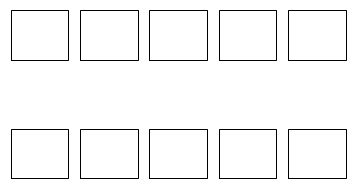

In [51]:
        
        
        #ax.set_extent([-95.0, -94.5, 29.2, 29.4], pc)
#         gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# #         # the following two make the labels look like lat/lon format
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        
#         ax.set_extent([-95.0, -94.5, 29.2, 29.4], pc)
#         gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
#         # the following two make the labels look like lat/lon format
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
#         gl.xlabels_bottom = False  # turn off labels where you don't want them
#         gl.ylabels_right = False
#         ax.add_feature(land_10m, facecolor='0.8')
#         ax.set_facecolor('0.8')
#         mappable = ax.scatter(df['ADU800-GGA-Lon']['2018-3-25 06:30':'2018-3-25 07:30'], df['ADU800-GGA-Lat']['2018-3-25 06:30':'2018-3-25 07:30'], c=df['Thermosalinograph-Data-Salinity']['2018-3-25 06:30':'2018-3-25 07:30'], s=200, cmap=cmo.haline, transform=pc,alpha=0.1, zorder=10)


In [ ]:
# fig, axes = plt.subplots(nrows=#, ncols=#)

# for row in ax:
#     for col in row: 
#             col.plot(x,y)
            
# plt.show()

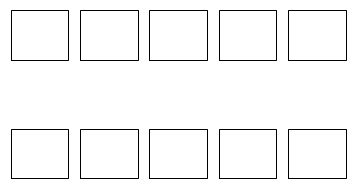

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=5,subplot_kw=dict(projection=merc))